In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.5 MB/s eta 0:00:00


In [2]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00


In [3]:
from typing import List, Dict, Callable, Optional, Union, Tuple, Any

import os
import logging

import random

import torch as th
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning.utilities.types import STEP_OUTPUT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
from transformers import get_linear_schedule_with_warmup

import torchvision.transforms.functional as F
import torchvision.transforms as T
import albumentations as A

import open_clip

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Models

In [4]:
class HeadV1(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(),
            nn.LeakyReLU(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV4(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV5(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(p=0.9),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV6(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(p=0.75),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV2(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV3(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Linear(f_in, f_in, bias=False),
            nn.BatchNorm1d(f_in),
            nn.LeakyReLU(),
            nn.Dropout1d(),
            nn.Linear(f_in, f_in, bias=False),
            nn.BatchNorm1d(f_in),
            nn.LeakyReLU(),
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class CLIPClassifier(nn.Module):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        data: str = "datacomp_xl_s13b_b90k",
        head_version: int = 1,
    ):
        super().__init__()
        self.backbone = open_clip.create_model_and_transforms(
            model_name, pretrained=data
        )[0].visual

        if model_name == "ViT-L-14":
            self.n = 768
            self.lrs = dict(
                back_lrs={"8": 1.25e-6, "16": 2.5e-6, "20": 5e-6, "24": 10e-6},
                back_wd=1e-3,
                hd_lr=3e-4,
                hd_wd=1e-5,
            )
        elif model_name == "ViT-H-14":
            self.n = 1024
            self.lrs = {
                "back_lrs": {"10": 1.25e-6, "20": 2.5e-6, "26": 5e-6, "32": 10e-6},
                "back_wd": 1e-3,
                "hd_lr": 3e-4,
                "hd_wd": 1e-5,
            }
        elif model_name == "ViT-B-16":
            self.n = 512
            self.lrs = {
                "back_lrs": {"1": 2.5e-6, "7": 5e-6, "12": 10e-6},
                "back_wd": 1e-3,
                "hd_lr": 3e-4,
                "hd_wd": 1e-5,
            }
        else:
            raise ValueError

        if head_version == 2:
            self.label = HeadV2(n_classes, self.n)
        elif head_version == 3:
            self.label = HeadV3(n_classes, self.n)
        elif head_version == 4:
            self.label = HeadV4(n_classes, self.n)
        elif head_version == 5:
            self.label = HeadV5(n_classes, self.n)
        elif head_version == 6:
            self.label = HeadV6(n_classes, self.n)
        else:
            self.label = HeadV1(n_classes, self.n)

        self.n_classes = n_classes

    def forward(self, x: th.tensor) -> th.tensor:
        x = self.backbone(x)
        return self.label(x)

    def get_parameter_section(self, parameters, lr=None, wd=None):
        # https://github.com/IvanAer/G-Universal-CLIP
        parameter_settings = []

        lr_is_dict = isinstance(lr, dict)
        wd_is_dict = isinstance(wd, dict)

        layer_no = None
        for n, p in parameters:
            for split in n.split("."):
                if split.isnumeric():
                    layer_no = int(split)

            if not layer_no:
                layer_no = 0

            if lr_is_dict:
                for k, v in lr.items():
                    if layer_no < int(k):
                        temp_lr = v
                        break
            else:
                temp_lr = lr

            if wd_is_dict:
                for k, v in wd.items():
                    if layer_no < int(k):
                        temp_wd = v
                        break
            else:
                temp_wd = wd

            parameter_setting = {"params": p, "lr": temp_lr, "weight_decay": temp_wd}
            parameter_settings.append(parameter_setting)
        return parameter_settings

    def get_learnable_params(self) -> list:
        back_lrs = self.lrs["back_lrs"]
        back_wd = self.lrs["back_wd"]
        hd_lr = self.lrs["hd_lr"]
        hd_wd = self.lrs["hd_wd"]

        parameter_settings = []

        if back_lrs and back_wd:
            parameter_settings.extend(
                self.get_parameter_section(
                    [(n, p) for n, p in self.backbone.named_parameters()],
                    lr=back_lrs,
                    wd=back_wd,
                )
            )

        parameter_settings.extend(
            self.get_parameter_section(
                [(n, p) for n, p in self.label.named_parameters()], lr=hd_lr, wd=hd_wd
            )
        )

        return parameter_settings

# Dataloader

In [5]:
def pre_process(_: str) -> T.Compose:
    return T.Compose(
        [
            T.ToTensor(),
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )


def aug(data_aug: str = "image_net") -> T.Compose:
    transform = T.Compose(
        [
            T.ToPILImage(),
            T.Resize(
                size=(224, 224),
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True,
            ),
        ]
    )
    if data_aug == "image_net":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )

    elif data_aug == "hca":
        aug8p3 = A.OneOf(
            [
                A.Sharpen(p=0.3),
                A.ToGray(p=0.3),
                A.CLAHE(p=0.3),
            ],
            p=0.5,
        )

        blur = A.OneOf(
            [
                A.GaussianBlur(p=0.3),
                A.MotionBlur(p=0.3),
            ],
            p=0.5,
        )

        transform = A.Compose(
            [
                A.ShiftScaleRotate(
                    rotate_limit=45,
                    scale_limit=0.1,
                    border_mode=cv2.BORDER_REFLECT,
                    interpolation=cv2.INTER_CUBIC,
                    p=0.5,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                aug8p3,
                blur,
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ElasticTransform(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ]
        )
    elif data_aug == "aug_mix":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AugMix(),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )
    elif data_aug == "happy_whale":
        aug8p3 = A.OneOf(
            [
                A.Sharpen(p=0.3),
                A.ToGray(p=0.3),
                A.CLAHE(p=0.3),
            ],
            p=0.5,
        )

        transform = A.Compose(
            [
                A.ShiftScaleRotate(
                    rotate_limit=15,
                    scale_limit=0.1,
                    border_mode=cv2.BORDER_REFLECT,
                    p=0.5,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                aug8p3,
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ]
        )

    elif data_aug == "cut_out":
        transform = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.ImageCompression(quality_lower=99, quality_upper=100),
                A.ShiftScaleRotate(
                    shift_limit=0.2,
                    scale_limit=0.2,
                    rotate_limit=10,
                    border_mode=cv2.BORDER_REFLECT,
                    p=0.7,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                A.Cutout(
                    max_h_size=int(224 * 0.4),
                    max_w_size=int(224 * 0.4),
                    num_holes=1,
                    p=0.5,
                ),
            ]
        )
    elif data_aug == "clip":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=(0.9, 1.0),
                    ratio=(0.75, 1.3333),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )
    elif data_aug == "clip+image_net":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=(0.9, 1.0),
                    ratio=(0.75, 1.3333),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )

    return transform


def read_image_cv2(f_name: str, gray_scale: bool = False) -> np.ndarray:
    img = cv2.imread(
        f_name, cv2.IMREAD_ANYCOLOR if not gray_scale else cv2.IMREAD_GRAYSCALE
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def class_balancing(df: pd.DataFrame) -> pd.DataFrame:
    counts = df.class_label.value_counts().to_dict()
    max_label = max(list(counts.items()), key=lambda x: x[1])

    for key, value in counts.items():
        if key == max_label[0]:
            continue

        df_label = df[df.class_label == key].sample(
            n=max_label[1] - value, replace=True
        )
        df = pd.concat([df, df_label])

    return df


class SimpleClassificationDataset(Dataset):
    def __init__(
        self,
        annotations_df: pd.DataFrame,
        img_dir: str,
        class_dict: dict,
        transform: Optional[T.Compose] = None,
        data_augment: Optional[Union[T.Compose, A.Compose]] = None,
        class_balance: bool = True,
    ):
        self.df = annotations_df
        if class_balance:
            self.df = class_balancing(annotations_df)

        self.img_dir = img_dir
        self.class_dict = class_dict
        self.transform = transform
        self.data_augment = data_augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cv2.setNumThreads(6)

        f_name, _, _, x_tl, y_tl, x_br, y_br, label = self.df.iloc[idx]

        img = read_image_cv2(os.path.join(self.img_dir, f_name))
        img_ = img[y_tl:y_br, x_tl:x_br, :]
        if img_.shape[0] * img_.shape[1] != 0:
            img = img_

        if self.data_augment:
            if isinstance(self.data_augment, A.Compose):
                img = self.data_augment(image=img)["image"]
            else:
                img = self.data_augment(img)

        if self.transform:
            img = self.transform(img)

        if self.class_dict:
            label = self.class_dict[label]
        return {"img": img, "label": label}

# Classification

In [6]:
def f1(y_true: th.Tensor, y_pred: th.Tensor):
    y_pred = th.round(y_pred)
    tp = th.sum((y_true * y_pred).float(), dim=0)
    tn = th.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = th.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = th.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = th.where(th.isnan(f1), th.zeros_like(f1), f1)
    return th.mean(f1)


def f1_loss(y_true: th.Tensor, y_pred: th.Tensor):
    tp = th.sum((y_true * y_pred).float(), dim=0)
    tn = th.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = th.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = th.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = th.where(th.isnan(f1), th.zeros_like(f1), f1)
    return 1 - th.mean(f1)


def accuracy(y1: th.Tensor, y2: th.Tensor):
    y1_argmax = y1.argmax(dim=1)
    y2_argmax = y2.argmax(dim=1)

    correct_sum = th.sum(y1_argmax == y2_argmax)
    return correct_sum / len(y1)


class MosquitoClassifier(pl.LightningModule):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        dataset: str = "datacomp_xl_s13b_b90k",
        freeze_backbones: bool = False,
        head_version: int = 0,
        warm_up_steps: int = 2000,
        bs: int = 64,
        data_aug: str = "",
        loss_func: str = "ce",
        epochs: int = 5,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.cls = CLIPClassifier(n_classes, model_name, dataset, head_version)
        if freeze_backbones:
            self.freezebackbone()

        self.scheduler = None
        self.n_classes = n_classes
        self.warm_up_steps = warm_up_steps
        self.loss_func = loss_func

        self.val_labels_t = []
        self.val_labels_p = []

        self.train_labels_t = []
        self.train_labels_p = []

    def freezebackbone(self) -> None:
        for param in self.cls.backbone.parameters():
            param.requires_grad = False

    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.cls(x)

    def lr_schedulers(self):
        # over-write this shit
        return self.scheduler

    def configure_optimizers(self):
        optimizer = th.optim.AdamW(self.cls.get_learnable_params())
        self.scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.warm_up_steps,
            num_training_steps=12800,  # not sure what to set
        )
        return optimizer

    def compute_loss(self, label_t: th.Tensor, label_p: th.Tensor) -> th.Tensor:
        if self.loss_func == "f1":
            label_loss = f1_loss(label_t, th.nn.functional.softmax(label_p, dim=1))
        elif self.loss_func == "ce+f1":
            label_loss = f1_loss(
                label_t, th.nn.functional.softmax(label_p, dim=1)
            ) + nn.CrossEntropyLoss()(label_p, label_t)
        else:
            label_loss = nn.CrossEntropyLoss()(label_p, label_t)

        return label_loss

    def training_step(self, train_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            train_batch["img"],
            train_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.train_labels_t.append(label_t.detach().cpu())
        self.train_labels_p.append(label_p.detach().cpu())

        self.log("train_loss", label_loss)

        if self.scheduler is not None:
            self.scheduler.step()

        return label_loss

    def on_train_epoch_end(self) -> None:
        label_p = th.concatenate(self.train_labels_p)
        label_t = th.concatenate(self.train_labels_t)

        self.log_dict(
            {
                "train_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_accuracy": accuracy(label_t, label_p),
            }
        )

        self.train_labels_t = []
        self.train_labels_p = []

    def validation_step(self, val_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            val_batch["img"],
            val_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.val_labels_t.append(label_t.detach().cpu())
        self.val_labels_p.append(label_p.detach().cpu())

        self.log("val_loss", label_loss)

        return label_loss

    def on_validation_epoch_end(self):
        label_p = th.concatenate(self.val_labels_p)
        label_t = th.concatenate(self.val_labels_t)

        self.log_dict(
            {
                "val_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_accuracy": accuracy(label_t, label_p),
            }
        )

        self.val_labels_t = []
        self.val_labels_p = []

    def on_epoch_end(self):
        opt = self.optimizers(use_pl_optimizer=True)
        self.log("lr", opt.param_groups[0]["lr"])

# Experiments

In [7]:
def _default_callbacks() -> List[Callback]:
    return [
        ModelCheckpoint(
            monitor="val_f1_score",
            mode="max",
            save_top_k=2,
            save_last=True,
            filename="{epoch}-{val_loss}-{val_f1_score}-{val_multiclass_accuracy}",
        ),
    ]


CLASS_DICT = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.float),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.float),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.float),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.float),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.float),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.float),
}


class ExperimentMosquitoClassifier:
    def __init__(
        self,
        img_dir: str,
        annotations_csv: str,
        class_dict: Dict[str, th.Tensor] = CLASS_DICT,
    ):
        self.img_dir = img_dir
        self.annotations_csv = annotations_csv
        self.class_dict = class_dict

    def get_dataloaders(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        model_name: str,
        data_aug: str,
        bs: int,
    ) -> List[DataLoader]:
        transform = pre_process(model_name)

        train_dataset = SimpleClassificationDataset(
            train_df,
            self.img_dir,
            self.class_dict,
            transform,
            aug(data_aug),
        )
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=bs,
            shuffle=True,
            num_workers=2,
            drop_last=True,
        )

        val_dataset = SimpleClassificationDataset(
            val_df,
            self.img_dir,
            self.class_dict,
            transform,
            aug("resize"),
            class_balance=False,
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=bs,
            shuffle=False,
            num_workers=2,
        )

        return train_dataloader, val_dataloader

    def run(
        self,
        model_name: str,
        dataset: str,
        bs: int,
        head_version: int,
        data_aug: str,
        freeze_backbones: bool = False,
        warm_up_steps: int = 2000,
        epochs: int = 5,
        create_callbacks: Callable[[], List[Callback]] = _default_callbacks,
    ):
        annotations_df = pd.read_csv(self.annotations_csv)
        train_df, val_df = train_test_split(
            annotations_df,
            test_size=0.2,
            stratify=annotations_df["class_label"],
            random_state=200,
        )

        train_dataloader, val_dataloader = self.get_dataloaders(
            train_df, val_df, model_name, data_aug, bs
        )

        th.set_float32_matmul_precision("high")
        model = MosquitoClassifier(
            model_name=model_name,
            dataset=dataset,
            freeze_backbones=freeze_backbones,
            head_version=head_version,
            warm_up_steps=warm_up_steps,
            bs=bs,
            data_aug=data_aug,
            epochs=epochs,
        )
        trainer = pl.Trainer(
            accelerator="gpu",
            precision="16-mixed",
            max_epochs=epochs,
            logger=True,
            deterministic=True,  # maybe we should add this
            callbacks=create_callbacks(),
        )

        trainer.fit(
            model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
        )

    def run_cross_validation(
        self,
        model_name: str,
        dataset: str,
        bs: int,
        head_version: int,
        data_aug: str,
        freeze_backbones: bool = False,
        warm_up_steps: int = 2000,
        epochs: int = 5,
        n_splits: int = 5,
        create_callbacks: Callable[[], List[Callback]] = _default_callbacks,
    ):
        annotations_df = pd.read_csv(self.annotations_csv)
        skf = StratifiedKFold(n_splits=n_splits)

        for _, (train_index, val_index) in enumerate(
            skf.split(annotations_df, annotations_df.class_label)
        ):
            train_df = annotations_df.iloc[train_index]
            val_df = annotations_df.iloc[val_index]

            train_dataloader, val_dataloader = self.get_dataloaders(
                train_df, val_df, model_name, data_aug, bs
            )

            th.set_float32_matmul_precision("high")
            model = MosquitoClassifier(
                model_name=model_name,
                dataset=dataset,
                freeze_backbones=freeze_backbones,
                head_version=head_version,
                warm_up_steps=warm_up_steps,
                bs=bs,
                data_aug=data_aug,
                epochs=epochs,
            )
            trainer = pl.Trainer(
                accelerator="gpu",
                precision="16-mixed",
                max_epochs=epochs,
                logger=True,
                callbacks=create_callbacks(),  # if I pass it as list of callbacks it doesn't work
                deterministic=True,  # maybe we should add this
                # TODO: we need some naming convention
            )

            trainer.fit(
                model=model,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )

In [8]:
img_dir = "/kaggle/input/mosquito-data-round-2/phase2_train_v0/final/"
annotations_csv = "/kaggle/input/mosquito-data-round-2/phase2_train_v0.csv"

In [9]:
annotations_df = pd.read_csv(annotations_csv)
annotations_df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,train_00000.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,train_00001.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,train_00002.jpeg,768,1024,220,58,659,808,albopictus
3,train_00003.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,train_00004.jpeg,1024,1365,129,231,697,1007,culex


/tmp/ipykernel_28/1508688053.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_bbox = th.tensor(


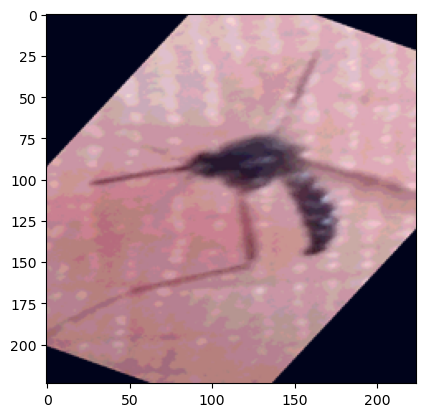

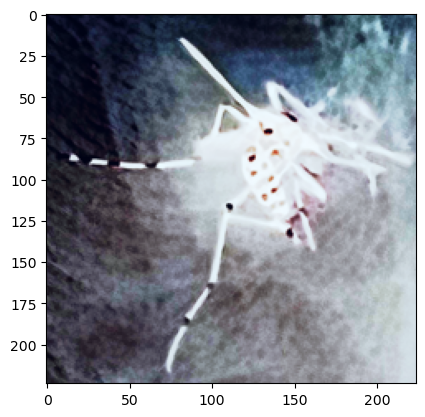

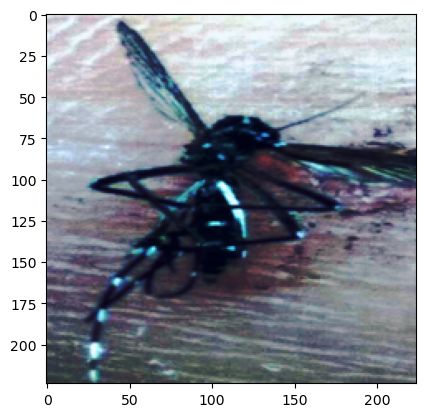

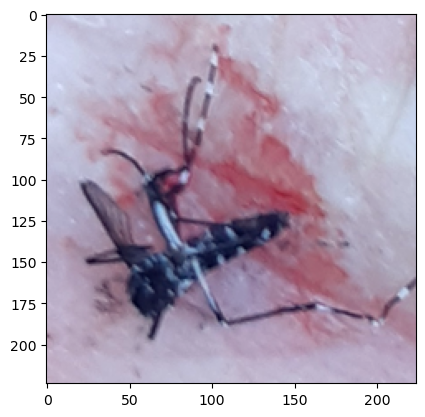

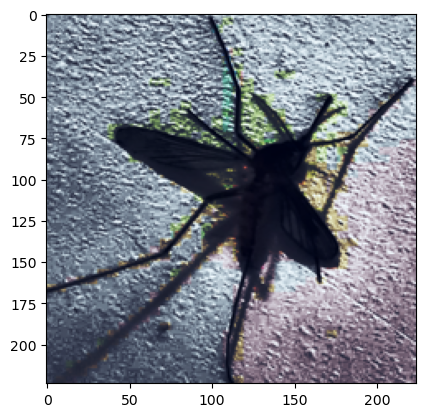

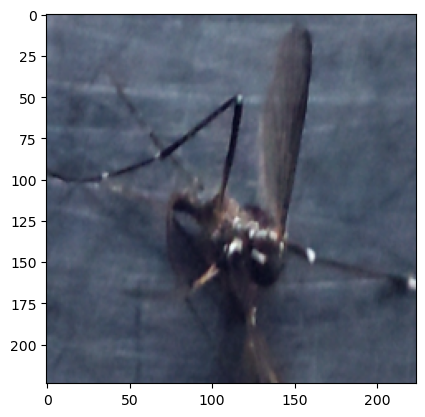

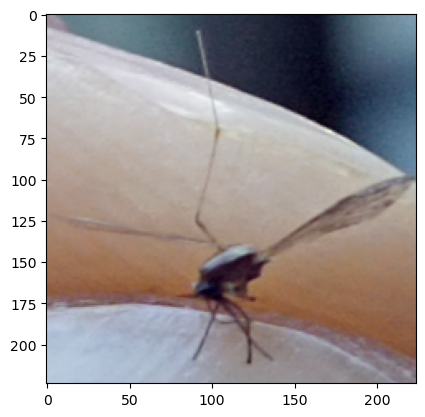

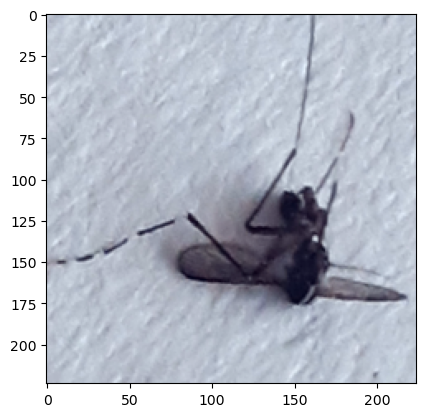

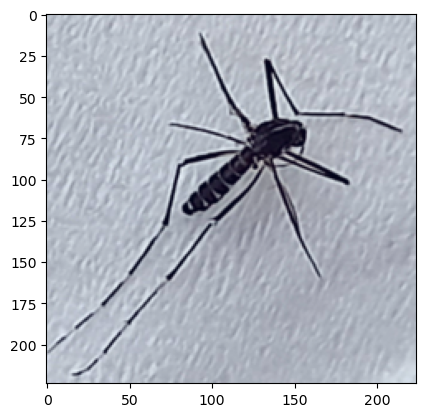

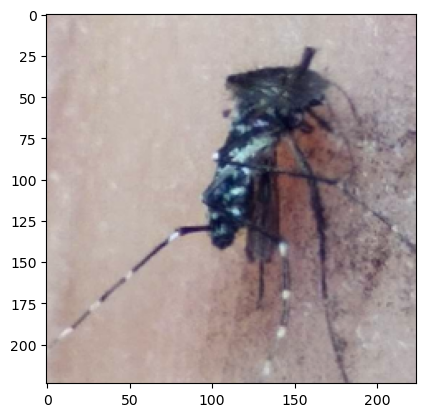

In [10]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

class_dict = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.long),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.long),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.long),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.long),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.long),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.long),
}

transform = pre_process("")

data_augmentation = aug("image_net")

ds = SimpleClassificationDataset(
    annotations_df=annotations_df,
    img_dir=img_dir,
    class_dict=class_dict,
    transform=transform,
    data_augment=data_augmentation,
)
for i in range(10):
    res = ds[i]
    img = res["img"]

    img_bbox = th.tensor(
        255 * (img - img.min()) / (img.max() - img.min()), dtype=th.uint8
    )
    show(img_bbox)
    plt.show()

In [11]:
exp = ExperimentMosquitoClassifier(img_dir, annotations_csv)

params = []
for data_aug in ["image_net", "happy_whale", "hca"]:
    for fb in [False]:
        for warm_up_steps in [1000, 1500]:
            for head_version in [2]:
                for model in [
                    ["ViT-B-16", "datacomp_l_s1b_b8k", 64],
                    ["ViT-L-14", "datacomp_xl_s13b_b90k", 64],
                ]:
                    param = model + [head_version, data_aug, fb, warm_up_steps]
                    params.append(param)

for data_aug in ["image_net", "happy_whale", "hca"]:
    for fb in [True]:
        for warm_up_steps in [100, 0]:
            for head_version in [2]:
                for model in [
                    ["ViT-B-16", "datacomp_l_s1b_b8k", 64],
                    ["ViT-L-14", "datacomp_xl_s13b_b90k", 64],
                ]:
                    param = model + [head_version, data_aug, fb, warm_up_steps]
                    params.append(param)

In [14]:
params = [['ViT-L-14', 'datacomp_xl_s13b_b90k', 64, 2, 'hca', True, 0]]

In [ ]:
print(f"Total experiments {len(params)}")
for param in params:
    print("Params:", param)
    exp.run(*param)

Total experiments 1
Params: ['ViT-L-14', 'datacomp_xl_s13b_b90k', 64, 2, 'hca', True, 0]


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]